# Forecasting error as a function of train/test set size

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!which python

In [3]:
import sys
sys.path.append('../src')

In [57]:
from darts import TimeSeries
import pandas as pd
from definitions import TARGETS
import matplotlib.pyplot as plt
import torch 
torch.cuda.empty_cache()
MEAS_COLUMNS = [
    "TI-19",
#      "FI-16",
#     "TI-33",
#     "FI-2",
#     "FI-151",
#     "TI-8",
#     "FI-241",
#  "valve-position-12",  # dry-bed
#     "FI-38",  # strippera
#     "PI-28",  # stripper
    
#     "TI-28",  # stripper
#      "FI-20",
#     "FI-30",
    "TI-3",
    "FI-19",
#     "FI-211",
    "FI-11",
#     "TI-30",
#     "PI-30",
    "TI-1213",
#     "TI-4",
#     "FI-23",
#     "FI-20",
#     "FI-20/FI-23",
#    "TI-22",
    "delta_t",
    "TI-35",
    "delta_t_2"
]

TARGETS_clean = ['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2', 
                 "Carbon dioxide CO2", "Ammonia NH3"]

TARGETS_clean = ["Carbon dioxide CO2", "Ammonia NH3"]


In [58]:
from pyprocessta.model.tcn import transform_data, run_model, parallelized_inference
from pyprocessta.preprocess.resample import resample_regular

In [59]:
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'

In [60]:
df = pd.read_pickle('20210624_df_cleaned.pkl')

In [61]:
df.columns

Index(['Carbon dioxide CO2', 'Ammonia NH3', '2-Amino-2-methylpropanol C4H11NO',
       'Piperazine C4H10N2', 'PI-2', 'TI-2', 'FI-2', 'PI-3', 'TI-3', 'CO2-3',
       'O2-3', 'TI-32', 'TI-33', 'TI-34', 'TI-35', 'PI-4', 'TI-4', 'FI-4',
       'CO2-4', 'NH3-4', 'FI-11', 'TI-12', 'TI-13', 'FI-20', 'FI-211',
       'TI-211', 'TI-8', 'TI-9', 'TI-5', 'TI-7', 'TI-28', 'PI-28', 'PI-30',
       'TI-30', 'FI-30', 'FI-38', 'PI-38', 'FI-36', 'TI-36', 'Reboiler duty',
       'FI-19', 'TI-19', 'PI-1', 'TI-1', 'FI-35', 'TI-39', 'FI-23', 'TI-22',
       'Level Desorber', 'Level Reboiler', 'TI-24', 'TI-25', 'FI-25', 'FI-16',
       'TI-16', 'FI-151', 'TI-151', 'TI-152', 'TI-212', 'FI-241', 'TI-241',
       'TI-242', 'valve-position-12', 'TI-1213', 'delta_t', 'delta_t_2',
       'FI-20/FI-23'],
      dtype='object')

In [62]:
y = TimeSeries.from_dataframe(df, value_cols=TARGETS_clean)
x = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)

In [10]:
def choose_index(series, fraction): 
    timestamps = series.time_index()
    fraction_index = int(len(timestamps) * fraction)
    
    return timestamps[fraction_index]

In [11]:
def split_data(x, y, fraction):
    ts = choose_index(x, fraction)
    x_before, x_after = x.split_before(ts)
    y_before, y_after = y.split_before(ts)
    
    return (x_before, y_before[TARGETS_clean]), (x_after, y_after[TARGETS_clean])

In [12]:
before, after  = split_data(x, y, 0.8)

In [13]:
train_tuple, test_tuple, scalers = transform_data(before, [after])
model = run_model(train_tuple, output_chunk_length=2)

/home/kjablonk/anaconda3/envs/timeseries_analysis/lib/python3.8/site-packages/torch/random.py:95: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of GPUs.  If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using.  For example, if you are using CPU only, set CUDA_VISIBLE_DEVICES= or devices=[]; if you are using GPU 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(
[2021-08-08 21:47:29,174] INFO | darts.models.torch_forecasting_model | Train dataset contains 4286 samples.
[2021-08-08 21:47:29,174] IN

(1082, 8) (1082, 2)


In [14]:
x_test, y_test = test_tuple[0]

In [15]:
x_train, y_train = train_tuple

In [16]:
backtest = model.historical_forecasts(y_test,
                          covariates=x_test,
                          start=0.2,
                          forecast_horizon=2,
                          stride=1,
                           verbose=False,
                          retrain=False)

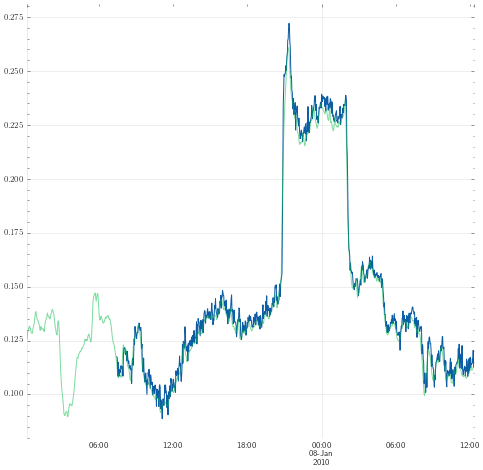

In [17]:
plt.figure(figsize=(8,8))
backtest['0'].plot()
y_test['0'].plot(alpha=.5)

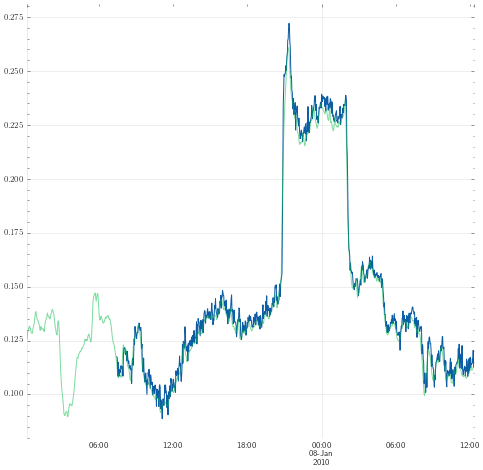

In [18]:
plt.figure(figsize=(8,8))
backtest['0'].plot()
y_test['0'].plot(alpha=.5)

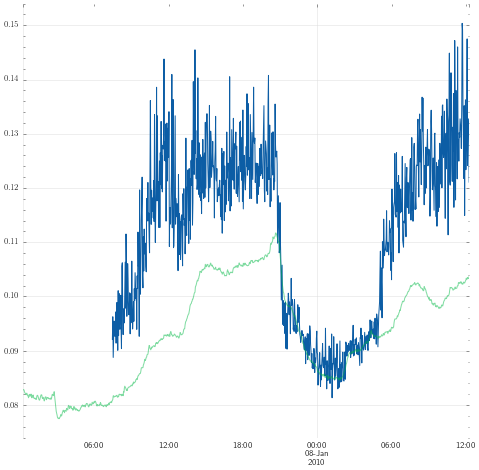

In [19]:
plt.figure(figsize=(8,8))
backtest['1'].plot()
y_test['1'].plot(alpha=.5)

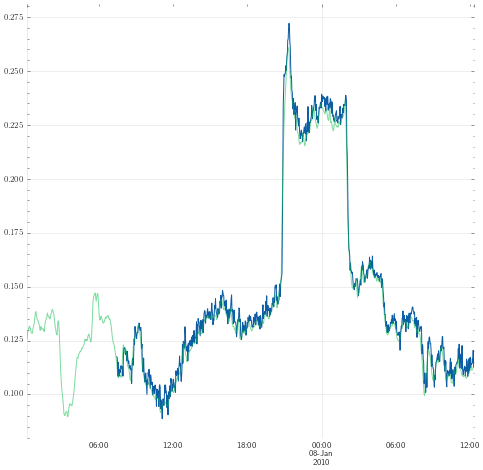

In [20]:
plt.figure(figsize=(8,8))
backtest['0'].plot()
y_test['0'].plot(alpha=.5)

In [21]:
from darts.metrics import mae, mape, marre, mase

In [46]:
metric_functions = [
    ('mae', mae), 
    ('mape', mape), 
    ('marre', marre)
]

def get_metrics(backtested, y_test): 
    start_index = backtested['0'][0].time_index()[0]
    start_index_m_1 = y_test['0'][:start_index][-2].time_index()[0]
    
    metrics = {}
    
    for target in ['0', '1']:
        metrics_f_target = {}
        for name, func in metric_functions: 
            metrics_f_target[name] = func(y_test[target][start_index:], backtested[target])
            
        metrics[target] = metrics_f_target
        
    return metrics



def get_metrics_for_target(backtested, y_test, target='0'): 
    start_index = backtested['0'][0].time_index()[0]
    start_index_m_1 = y_test[target][:start_index][-2].time_index()[0]
    
  
    metrics_f_target = {}
    for name, func in metric_functions: 
        metrics_f_target[name] = func(y_test[target][start_index:], backtested['0'])

    return metrics_f_target

        

In [47]:
get_metrics(backtest, y_test)

{'0': {'mae': 0.003627235151639537,
  'mape': 2.6067213164317353,
  'marre': 2.144372679791301},
 '1': {'mae': 0.015807966940445815,
  'mape': 16.233876014597843,
  'marre': 51.237525047269195}}

In [51]:
def split_train_backtest(x, y, fraction, forecast_horizon=2): 
    before, after  = split_data(x, y, fraction)
    print(len(before[0]), len(after[0]))
    train_tuple, test_tuple, scalers = transform_data(before, [after])
    model = run_model(train_tuple, output_chunk_length=forecast_horizon)
    x_test, y_test = test_tuple[0]
    x_train, y_train = train_tuple
    backtest = model.historical_forecasts(y_test,
                          covariates=x_test,
                          start=0.2,
                          forecast_horizon=forecast_horizon,
                          stride=1,
                           verbose=False,
                          retrain=False)
    
    return get_metrics(backtest, y_test)

In [48]:
def get_baseline_metrics(x, y, fraction): 
    before, after  = split_data(x, y, fraction)

    train_tuple, test_tuple, scalers = transform_data(before, [after])

    mean_model_0 = NaiveMean()
    mean_model_1 = NaiveMean()
    
    drift_model_0 = NaiveDrift()
    drift_model_1 = NaiveDrift()
    
    mean_model_0.fit(train_tuple[1]['0'])
    mean_model_1.fit(train_tuple[1]['1'])
    
    drift_model_0.fit(train_tuple[1]['0'])
    drift_model_1.fit(train_tuple[1]['1'])
    
    mean_model_0_backtest = mean_model_0.historical_forecasts(test_tuple[0][1]['0'], forecast_horizon=2)
    mean_model_0_backtest = mean_model_0_backtest.update(mean_model_0_backtest.time_index(), mean_model_0.predict(len(mean_model_0_backtest)).values().flatten())
    mean_model_1_backtest = mean_model_1.historical_forecasts(test_tuple[0][1]['1'], forecast_horizon=2)
    mean_model_1_backtest = mean_model_1_backtest.update(mean_model_1_backtest.time_index(), mean_model_1.predict(len(mean_model_1_backtest)).values().flatten())
        
    drift_model_0_backtest = drift_model_0.historical_forecasts(test_tuple[0][1]['0'], forecast_horizon=2)
    drift_model_0_backtest = drift_model_0_backtest.update(drift_model_0_backtest.time_index(), drift_model_0.predict(len(drift_model_0_backtest)).values().flatten())
    drift_model_1_backtest = drift_model_1.historical_forecasts(test_tuple[0][1]['1'], forecast_horizon=2)
    drift_model_1_backtest = drift_model_1_backtest.update(drift_model_1_backtest.time_index(), drift_model_1.predict(len(drift_model_1_backtest)).values().flatten())

    mean_model_metrics = {
        '0': get_metrics_for_target(mean_model_0_backtest, test_tuple[0][1]['0']),
        '1': get_metrics_for_target(mean_model_1_backtest, test_tuple[0][1]['1'], '1')
    }
    
    
    drift_model_metrics = {
        '0': get_metrics_for_target(drift_model_0_backtest, test_tuple[0][1]['0']),
        '1': get_metrics_for_target(drift_model_1_backtest, test_tuple[0][1]['1'], '1')
    }
    
    return mean_model_metrics, drift_model_metrics

In [49]:
baseline_metrics = []

for ratio in [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
    baseline_metrics.append(get_baseline_metrics(x, y, ratio))

(2705, 8) (2705, 2)
(2164, 8) (2164, 2)
(1623, 8) (1623, 2)
(1082, 8) (1082, 2)
(541, 8) (541, 2)
(271, 8) (271, 2)


In [26]:
import pickle

In [50]:
with open('20210805_baselines_amine.pkl', 'wb') as handle:
    pickle.dump(baseline_metrics, handle)

In [27]:
from darts.models.baselines import NaiveMean, NaiveDrift

In [28]:
mean_model = NaiveMean()
mean_model.fit(train_tuple[1]['0'])

In [29]:
drift_forecasts = mean_model.predict(10)

In [30]:
drift_forecasts.values().flatten()

array([0.15018673, 0.15018673, 0.15018673, 0.15018673, 0.15018673,
       0.15018673, 0.15018673, 0.15018673, 0.15018673, 0.15018673])

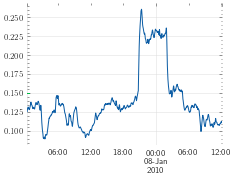

In [31]:
test_tuple[0][1]['0'].plot()
drift_forecasts.plot()

In [ ]:
collected_metrics = []

for i in range(10):
    metrics = {}

    for forecast_horizon in [1, 2, 4, 8, 16]: 
        metrics[forecast_horizon] = split_train_backtest(x, y, 0.6, forecast_horizon)
    
    collected_metrics.append(metrics)

[2021-08-16 08:51:54,240] INFO | darts.models.torch_forecasting_model | Train dataset contains 3205 samples.
[2021-08-16 08:51:54,240] INFO | darts.models.torch_forecasting_model | Train dataset contains 3205 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 09:10:45,396] INFO | darts.models.torch_forecasting_model | Train dataset contains 3204 samples.
[2021-08-16 09:10:45,396] INFO | darts.models.torch_forecasting_model | Train dataset contains 3204 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 09:30:01,180] INFO | darts.models.torch_forecasting_model | Train dataset contains 3202 samples.
[2021-08-16 09:30:01,180] INFO | darts.models.torch_forecasting_model | Train dataset contains 3202 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 09:49:34,138] INFO | darts.models.torch_forecasting_model | Train dataset contains 3198 samples.
[2021-08-16 09:49:34,138] INFO | darts.models.torch_forecasting_model | Train dataset contains 3198 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 10:08:49,332] INFO | darts.models.torch_forecasting_model | Train dataset contains 3190 samples.
[2021-08-16 10:08:49,332] INFO | darts.models.torch_forecasting_model | Train dataset contains 3190 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 10:27:54,792] INFO | darts.models.torch_forecasting_model | Train dataset contains 3205 samples.
[2021-08-16 10:27:54,792] INFO | darts.models.torch_forecasting_model | Train dataset contains 3205 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 10:47:35,233] INFO | darts.models.torch_forecasting_model | Train dataset contains 3204 samples.
[2021-08-16 10:47:35,233] INFO | darts.models.torch_forecasting_model | Train dataset contains 3204 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 11:06:19,360] INFO | darts.models.torch_forecasting_model | Train dataset contains 3202 samples.
[2021-08-16 11:06:19,360] INFO | darts.models.torch_forecasting_model | Train dataset contains 3202 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 11:25:26,372] INFO | darts.models.torch_forecasting_model | Train dataset contains 3198 samples.
[2021-08-16 11:25:26,372] INFO | darts.models.torch_forecasting_model | Train dataset contains 3198 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 11:44:35,439] INFO | darts.models.torch_forecasting_model | Train dataset contains 3190 samples.
[2021-08-16 11:44:35,439] INFO | darts.models.torch_forecasting_model | Train dataset contains 3190 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 12:03:49,064] INFO | darts.models.torch_forecasting_model | Train dataset contains 3205 samples.
[2021-08-16 12:03:49,064] INFO | darts.models.torch_forecasting_model | Train dataset contains 3205 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 12:23:14,276] INFO | darts.models.torch_forecasting_model | Train dataset contains 3204 samples.
[2021-08-16 12:23:14,276] INFO | darts.models.torch_forecasting_model | Train dataset contains 3204 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 12:43:07,780] INFO | darts.models.torch_forecasting_model | Train dataset contains 3202 samples.
[2021-08-16 12:43:07,780] INFO | darts.models.torch_forecasting_model | Train dataset contains 3202 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 13:02:06,743] INFO | darts.models.torch_forecasting_model | Train dataset contains 3198 samples.
[2021-08-16 13:02:06,743] INFO | darts.models.torch_forecasting_model | Train dataset contains 3198 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 13:21:04,921] INFO | darts.models.torch_forecasting_model | Train dataset contains 3190 samples.
[2021-08-16 13:21:04,921] INFO | darts.models.torch_forecasting_model | Train dataset contains 3190 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 13:40:40,504] INFO | darts.models.torch_forecasting_model | Train dataset contains 3205 samples.
[2021-08-16 13:40:40,504] INFO | darts.models.torch_forecasting_model | Train dataset contains 3205 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 13:59:56,053] INFO | darts.models.torch_forecasting_model | Train dataset contains 3204 samples.
[2021-08-16 13:59:56,053] INFO | darts.models.torch_forecasting_model | Train dataset contains 3204 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 14:18:54,990] INFO | darts.models.torch_forecasting_model | Train dataset contains 3202 samples.
[2021-08-16 14:18:54,990] INFO | darts.models.torch_forecasting_model | Train dataset contains 3202 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 14:38:29,751] INFO | darts.models.torch_forecasting_model | Train dataset contains 3198 samples.
[2021-08-16 14:38:29,751] INFO | darts.models.torch_forecasting_model | Train dataset contains 3198 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 14:57:53,112] INFO | darts.models.torch_forecasting_model | Train dataset contains 3190 samples.
[2021-08-16 14:57:53,112] INFO | darts.models.torch_forecasting_model | Train dataset contains 3190 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 15:17:05,191] INFO | darts.models.torch_forecasting_model | Train dataset contains 3205 samples.
[2021-08-16 15:17:05,191] INFO | darts.models.torch_forecasting_model | Train dataset contains 3205 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 15:36:17,077] INFO | darts.models.torch_forecasting_model | Train dataset contains 3204 samples.
[2021-08-16 15:36:17,077] INFO | darts.models.torch_forecasting_model | Train dataset contains 3204 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 15:55:20,446] INFO | darts.models.torch_forecasting_model | Train dataset contains 3202 samples.
[2021-08-16 15:55:20,446] INFO | darts.models.torch_forecasting_model | Train dataset contains 3202 samples.


3245 2164
(2164, 8) (2164, 2)


[2021-08-16 16:14:46,205] INFO | darts.models.torch_forecasting_model | Train dataset contains 3198 samples.
[2021-08-16 16:14:46,205] INFO | darts.models.torch_forecasting_model | Train dataset contains 3198 samples.


3245 2164
(2164, 8) (2164, 2)


In [ ]:
with open('20210816_collected_metrics_co2_seq_len.pkl', 'wb') as handle:
    pickle.dump(collected_metrics, handle)

In [18]:
import pickle

In [19]:
with open('metrics_lc.pkl', 'wb') as handle: 
    pickle.dump(metrics, handle)

In [34]:
collected_metrics

[{0.5: {'0': {'mae': 0.018198414381966524,
    'mape': 4.692313066654013,
    'marre': 2.7626717299024},
   '1': {'mae': 0.01302071799811611,
    'mape': 14.95294997413609,
    'marre': 35.83293326028175}},
  0.6: {'0': {'mae': 0.011243985327299784,
    'mape': 8.795642308846114,
    'marre': 5.499861623618583},
   '1': {'mae': 0.010659678980816949,
    'mape': 11.470162448276058,
    'marre': 29.537692647788955}},
  0.7: {'0': {'mae': 0.008307372302569898,
    'mape': 6.307457929516383,
    'marre': 4.855081831109471},
   '1': {'mae': 0.007752790779111324,
    'mape': 8.23105284338276,
    'marre': 22.638480816770084}},
  0.8: {'0': {'mae': 0.0036654235012765725,
    'mape': 2.4930571988040136,
    'marre': 2.1669491189314445},
   '1': {'mae': 0.006931451484026359,
    'mape': 7.160463915218282,
    'marre': 22.466546164013916}},
  0.9: {'0': {'mae': 0.002943703525353472,
    'mape': 1.8349032551057753,
    'marre': 2.1561091219920216},
   '1': {'mae': 0.0017732226491613695,
    'mape